# Introduction to Machine Learning - Exercise 5
* Goal of the excercise is to learn how to use **K-means** implementation in the Scikit-learn library to perform clustering and subsequent cluster analysis on a Titanic dataset.

## 🔎 Let's discuss the clustering topic a bit first
* What task do clustering algorithms solve?
* Do you know any examples of such algorithms?
* What are the limitation of clustering algorithms?

## 🔎 What is the **most difficult** of the clustering tasks?

![meme01](https://github.com/lubsar/EFREI-Introduction-to-Machine-Learning/blob/main/images/fml_04_meme_01.jpg?raw=true)

## 💡 But don't worry we will deal with the topic in several lectures 😊

## Import the libraries
* 🔎  What is the **sklearn** library?

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns

# We will work with the famous Titanic dataset ⛵

## Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

* Dataset is available at https://www.kaggle.com/competitions/titanic'

## Load dataset
* https://raw.githubusercontent.com/rasvob/EFREI-Introduction-to-Machine-Learning/main/datasets/titanic.csv

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lubsar/EFREI-Introduction-to-Machine-Learning/main/datasets/titanic.csv', index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## How many missing values do we have in the data?

In [3]:
df.isna().sum().sort_values(ascending=False)

,0
Cabin,687
Age,177
Embarked,2
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0
Fare,0


## We are going to cluster the passangers into defined number of groups
* It is clear that it is mandatory to select only a relevant subset of features
    * Name the new DF as *df_clustering*
* 🔎 Is *Name* or *Ticket* relevant?
    * 'Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'

1. Select the features
2. Drop *NaN* values
3. Change type of *Sex* and *Embarked* to string
    * **astype()** function

In [4]:
df_clustering = df[['Survived', 'Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].copy()
df_clustering = df_clustering.dropna()
df_clustering.Sex = df_clustering.Sex.astype(str)
df_clustering.Embarked = df_clustering.Embarked.astype(str)
df_clustering.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


## Check *shape* and *dtypes*

In [5]:
df_clustering.shape

(712, 8)

In [6]:
df_clustering.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Fare,float64
Embarked,object


# Print the dataset

## 🔎 Does everything seem OK?

In [7]:
df_clustering

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,3,female,39.0,0,5,29.1250,Q
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S


# We can see that not all features are numerical
* 🔎 Is it a problem?
    * Why?
* 🔎 How to deal with it?

## We have two basic encoding options
* Ordinal encoding vs. One-hot encoding
* What is the difference?
    * Is thete difference in dimensionality change? Why it can be an issue?
    * When is ordinal encoding appropriate?
    * Can you omit the pre-requirements of ordinal encoding sometimes?

## Lets encode categorical features
* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
* https://scikit-learn.org/stable/modules/classes.html?highlight=preprocessing#module-sklearn.preprocessing



In [11]:
enc = sklearn.preprocessing.OrdinalEncoder()
enc.fit_transform(df_clustering[['Sex']])


array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],

In [12]:
enc.categories_

[array([0., 1.])]

## 💡 You may ask why do we use the `dataframe[['feature_name']]` notation with double `[[` and `]]` brackets
* **Single brackets** pair around one variable name means that you want to select just the `pandas.Series` object

In [13]:
type(df_clustering['Sex'])

pandas.core.series.Series

* **Double brackets** pair around one variable name created an output in the `pandas.DataFrame` format

In [14]:
type(df_clustering[['Sex']])

pandas.core.frame.DataFrame

In [16]:
df_clustering['Embarked'].value_counts()

,count
Embarked,
2.0,554
0.0,130
1.0,28


## There is OneHotEncoder as well, however I recommend using `pd.get_dummies` method instead

In [17]:
pd.get_dummies(df_clustering['Embarked'])

,0.0,1.0,2.0
PassengerId,,,
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True
5,False,False,True
...,...,...,...
886,False,True,False
887,False,False,True
888,False,False,True


## Let's finish the encoding part and create a new dataframe with encoded data
1. Create empty *df_encoded* dataframe with index using *df_clustering.index*
2. Create *Sex* variable with ordinal encoded data
3. Use `join` method for added one-hot encoded *Embarked* feature

In [19]:
df_encoded = pd.DataFrame(index=df_clustering.index)
df_encoded['Sex'] = sklearn.preprocessing.OrdinalEncoder().fit_transform(df_clustering[['Sex']])
df_encoded = df_encoded.join(pd.get_dummies(df_clustering['Embarked']))

In [21]:
df_encoded.head()

,Sex,0.0,1.0,2.0
PassengerId,,,,
1,1.0,False,False,True
2,0.0,True,False,False
3,0.0,False,False,True
4,0.0,False,False,True
5,1.0,False,False,True


# It is important to select the appropriate scaling method of the number features
* There are many ways how to do this - **MinMax, StandardScaler, PowerTransform, ...**
* This step heavily depends on a domain knowledge because the scales of the features have significant effect on a distances between couples of dataset instances
    - It is clear that if one variable is in range **(0,1)** and the second one is in a range **(5000, 10 000)**, the difference in the **second feature** will be definitely **more important** than in the  first one from the numerical point of view
    - Although it is possible that from the **domain point of view** the **first variable may be more important**
    - 💡 Thus it is a good idea to at least transform the features into a **simiiar scales so the effect on the distance value would be similiar**
    - Transformation depends heavily on the statistical distribution of the feature
        - 💡You can use PowerTransform for a heavy-tailed distribution, **Standardization or MinMax normalization for normally distributed features** etc.

## Take a look at the *Fare* feature distribution
* What transformation would be appropriate based on that?

/tmp/ipython-input-173229531.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_clustering.Fare, bins = 25)


<Axes: xlabel='Fare', ylabel='Density'>

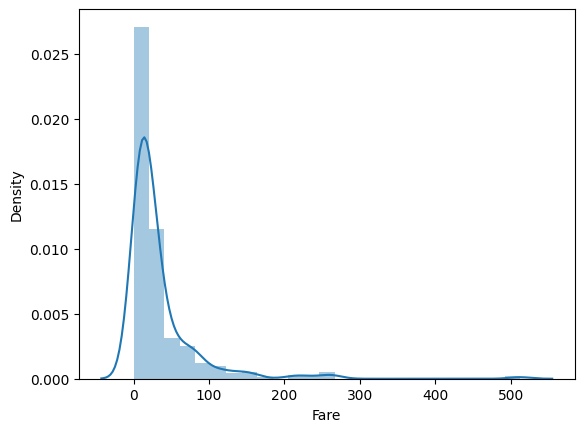

In [25]:
sns.distplot(df_clustering.Fare, bins = 25)

## Transform the feature

In [30]:
enc = sklearn.preprocessing.PowerTransformer()
enc.fit_transform(df_clustering[['Fare']])[:20]

array([[-0.99765031],
       [ 1.28775742],
       [-0.90107255],
       [ 1.02427568],
       [-0.88411158],
       [ 1.00273178],
       [ 0.13202717],
       [-0.53475875],
       [ 0.48661962],
       [-0.10705645],
       [ 0.36394683],
       [-0.88411158],
       [ 0.52494282],
       [-0.91080102],
       [-0.15160295],
       [ 0.45530075],
       [-0.029469  ],
       [ 0.34315814],
       [-0.36978947],
       [-0.88691511]])

## Add the transformed feature into the *df_encoded* dataframe

In [31]:
df_encoded['Fare'] = sklearn.preprocessing.PowerTransformer().fit_transform(df_clustering[['Fare']])

## Plot histogram of the transformed feature
* 🔎 What has changed?

/tmp/ipython-input-2702438844.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_encoded.Fare, bins = 25)


<Axes: xlabel='Fare', ylabel='Density'>

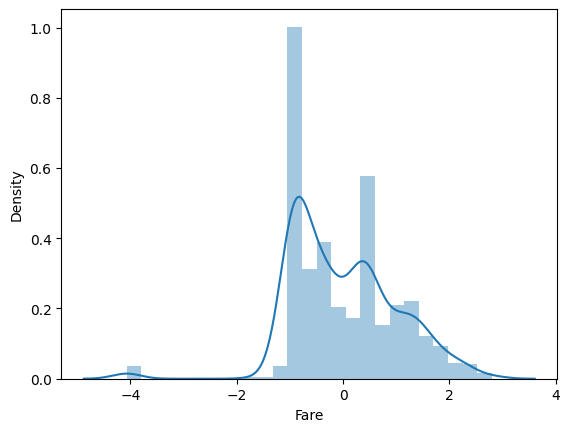

In [32]:
sns.distplot(df_encoded.Fare, bins = 25)

## Scale the *Age* using MinMax scaler
* `sklearn.preprocessing.minmax_scale`

In [33]:
df_encoded['Age'] = sklearn.preprocessing.minmax_scale(df_clustering.Age)

## Join the *df_encoded* and *['Survived', 'Pclass', 'SibSp', 'Parch']* features

In [34]:
df_encoded = df_encoded.join(df_clustering[['Survived', 'Pclass', 'SibSp', 'Parch']])

In [35]:
df_encoded

,Sex,0.0,1.0,2.0,Fare,Age,Survived,Pclass,SibSp,Parch
PassengerId,,,,,,,,,,
1,1.0,False,False,True,-0.997650,0.271174,0,3,1,0
2,0.0,True,False,False,1.287757,0.472229,1,1,1,0
3,0.0,False,False,True,-0.901073,0.321438,1,3,0,0
4,0.0,False,False,True,1.024276,0.434531,1,1,1,0
5,1.0,False,False,True,-0.884112,0.434531,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0.0,False,True,False,0.455301,0.484795,0,3,0,5
887,1.0,False,False,True,-0.369789,0.334004,0,2,0,0
888,0.0,False,False,True,0.484313,0.233476,1,1,0,0


# We finally got to the clustering part 😮‍💨

![meme02](https://github.com/lubsar/EFREI-Introduction-to-Machine-Learning/blob/main/images/fml_04_meme_02.jpg?raw=true)

## There are methods how to identify probable number of clusters in the data
* It is always a rough estimate

## 💡 We can use **Elbow method** to identify potentially ideal number of clusters in our data in **KMeans** algorithm.

There are two basic methods for evaluation of clusters quality:
1. SSE - Sum of squared distances of samples to their closest cluster center, this one is specific for **KMeans** algorithm.
    * You can find it as **inertia_** attribute of KMeans sklearn object.
2. Silhouette Coefficient - calculated using the mean intra-cluster distance and the mean nearest-cluster distance

## 💡 We ussually want to find number of clusters with low SSE and high Silhoutte coef.
- Take a look at [this](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c) and [this](https://towardsdatascience.com/k-means-clustering-from-a-to-z-f6242a314e9a) for more details

## Try different number of clusters from range <2, 10> for KMeans algorithm, save both evaluation criteria and plot dependency of criteria to number of clusters.
* We will use `sklearn.cluster.KMeans` class
* The most important parameter is the *n_clusters*
    * What is the *random_state* parameter?

In [38]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k, random_state=41).fit(df_encoded)
    clustering_scores.append({'k':k, 'sse': clustering.inertia_, 'silouhette': sklearn.metrics.silhouette_score(df_encoded, clustering.labels_)})

,sse,silouhette
k,,
2,2051.762020,0.334082
3,1557.701272,0.369388
4,1346.322976,0.371333
5,1216.620876,0.304164
6,1130.390004,0.289005
7,1050.676355,0.280120
8,971.970925,0.288536
9,894.154511,0.302225
10,826.212989,0.293766


## Plot the SSE and Silhouette score

<Axes: xlabel='k', ylabel='sse'>

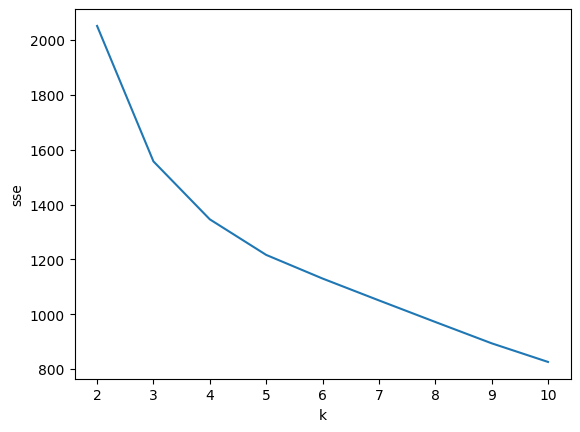

In [40]:
sns.lineplot(data=df_clustering_scores, y = 'sse', x = 'k')

<Axes: xlabel='k', ylabel='silouhette'>

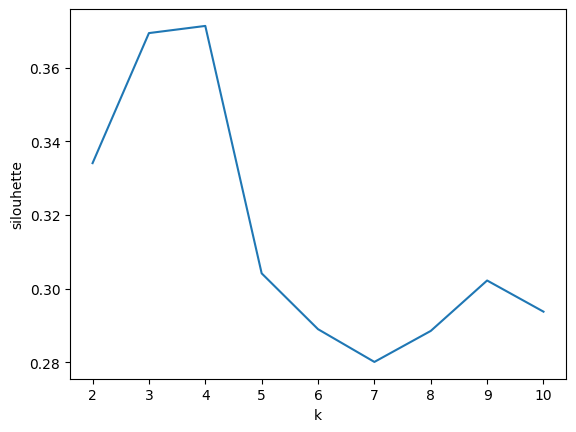

In [41]:
sns.lineplot(data=df_clustering_scores, y = 'silouhette', x = 'k')

# 🔎 What is the probable number of clusters in the data?

## Let's try to analyze the data assigned into **4** clusters

In [42]:
clustering = sklearn.cluster.KMeans(n_clusters=4, random_state=41, n_init='auto').fit(df_encoded)

## How big are our clusters? How many 0, 1, .. are in *labels_* property?

In [43]:
pd.Series(clustering.labels_).value_counts()

,count
0,387
1,181
3,109
2,35


# 📒 Explore clusters
* Try to use cluster information for exploration analysis of our data
    * Create new feature *cluster_id* with the *labels_* property data

In [44]:
df_clustering['cluster_id'] = clustering.labels_

## 🚀 Hint: You can use *sns.countplot* as a visual *.value_counts()* method

<Axes: xlabel='cluster_id', ylabel='count'>

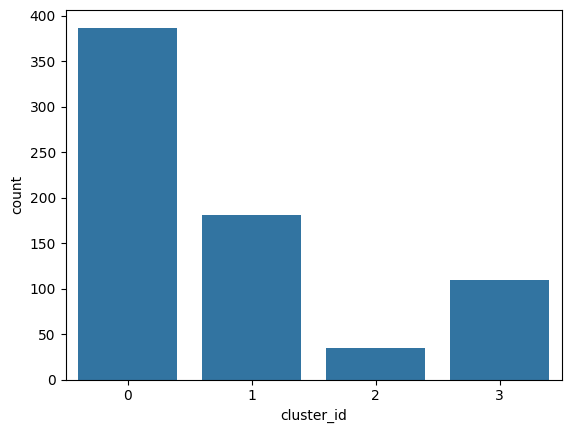

In [46]:
sns.countplot(data = df_clustering, x= 'cluster_id')

## 🎯 Create plots showing values of different attributes based on cluster group and describe them
* Let's follow the four example questions about the data to solve the task

### ❓ Questions ❓
1. Is **Fare** different for points in different clusters?
    * 💡 Use *plt.yscale('log')* to take care of the outlier/variance effect
2. Is **Age** different for point in different clusters?
3. Does rate of suvival differ in clusters?
    * *Survived*
4. Does number of passanger of each class differ in clusters?
    * *Pclass*

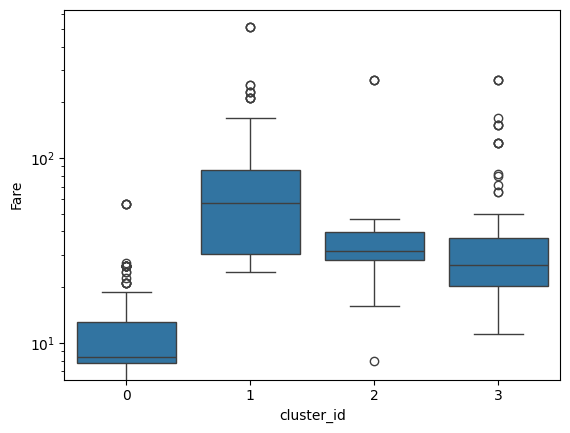

In [48]:
sns.boxplot(data=df_clustering, x='cluster_id', y='Fare')
plt.yscale('log')


<Axes: xlabel='cluster_id', ylabel='Age'>

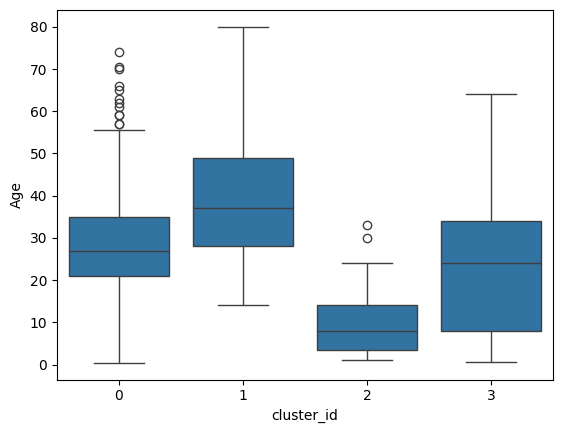

In [49]:
sns.boxplot(data=df_clustering, x='cluster_id', y='Age')


<Axes: xlabel='cluster_id', ylabel='count'>

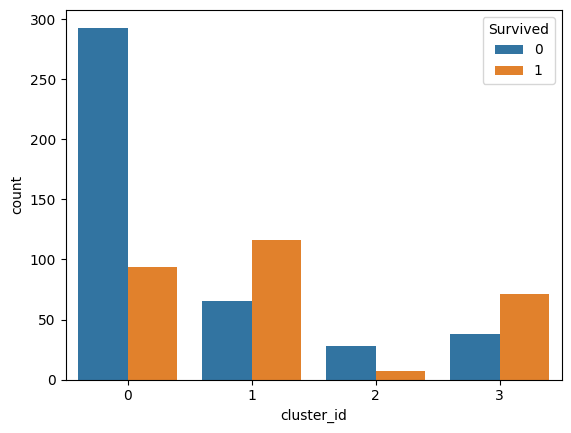

In [50]:
sns.countplot(data=df_clustering, x='cluster_id', hue='Survived')

# 📝 Write a textual description of the four clusters

### Cluster 1 - ...

### Cluster 2 - ...

### Cluster 3 - ...

### Cluster 4 - ...

# Is our data represented in the best way?

* **Clustering methods depends on calculation of distance metric among data points in our data matrix.**
* Therefore it is necessary to preproces our data matrix **X** in a best way possible to achive equal distance for every dataset feature.
    * After such transformation we can presume, that difference in *Age* has same impact as the difference as in the *Fare* feature.
* **Generally, it is very hard to create perfect tranformation for our real dataset.**

## Use StandardScaler transformation for our data **X**

# ✅ Task
1. Use **KMeans** to differently preprocessed data matrix **X_stand**
2. Detect "ideal" number of clusters using Elbow method
3. Explore detected clusters and **describe** them to the Markdown cell
    * **Describe the insight you got from the plots with a few sentences in a Markdown cell below the plot**

,sse,silhouette
k,,
2,5789.126424,0.242439
3,4975.199820,0.266185
4,4093.014058,0.293693
5,3735.228457,0.255866
6,2974.550743,0.293458
7,2688.200838,0.308198
8,2511.085785,0.306124
9,2415.580715,0.259923
10,2366.224512,0.252743


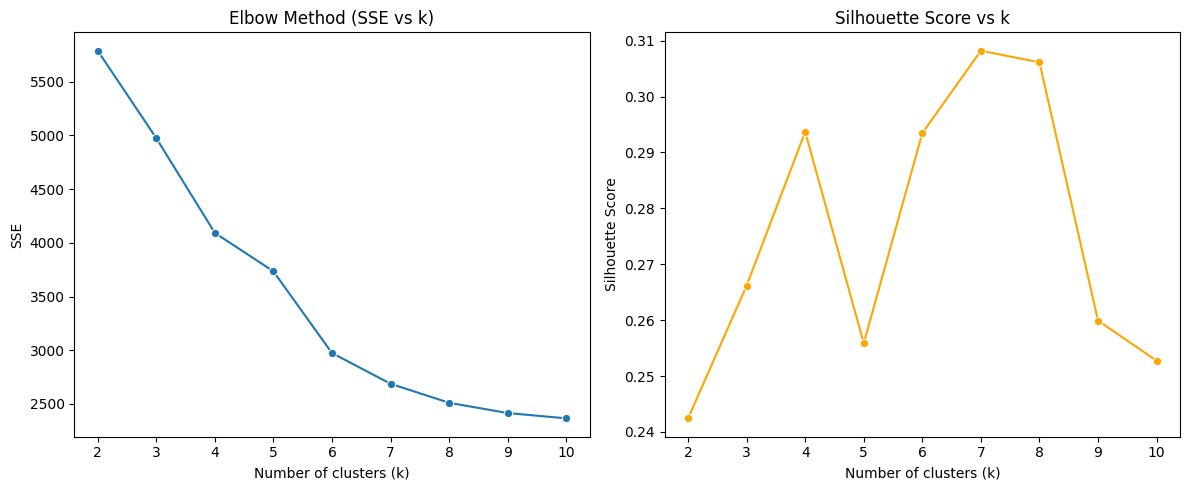

Taille des clusters :
0    345
1    184
3    131
2     52
Name: count, dtype: int64


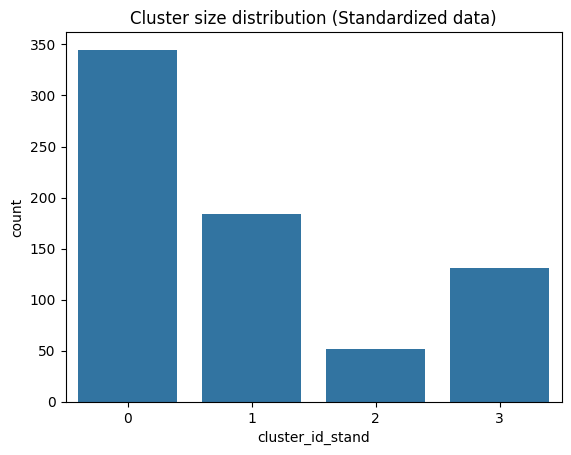

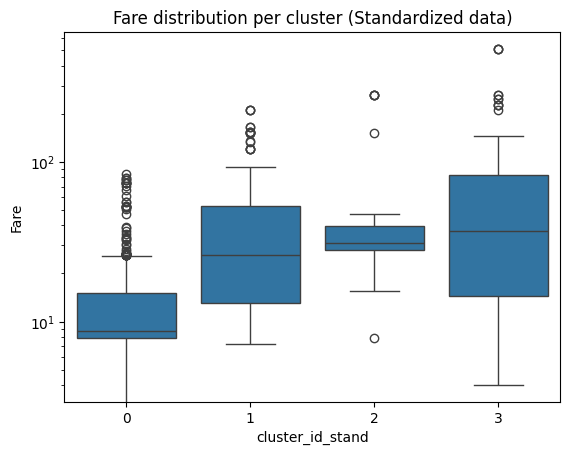

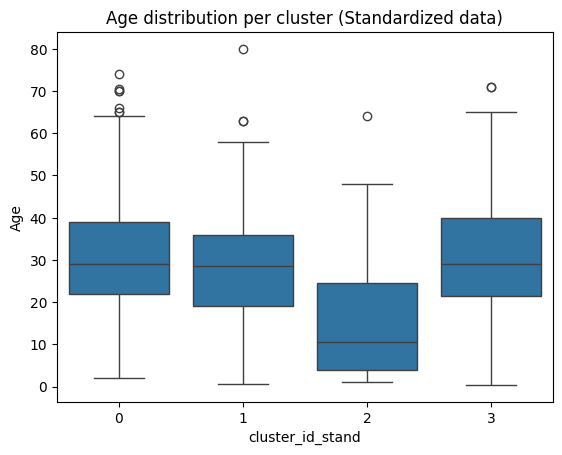

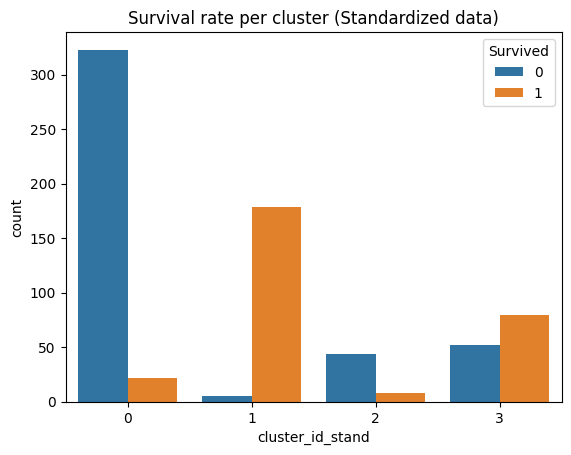

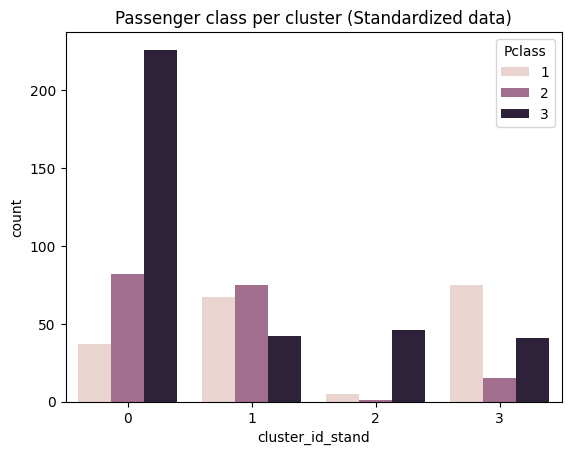

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_stand = df_encoded.copy()  # df_encoded = dataset après encodage (one-hot, etc.)
scaler = StandardScaler()
X_stand_scaled = scaler.fit_transform(X_stand)

# 2️⃣ Recherche du meilleur nombre de clusters (méthode du coude + silhouette)
clustering_scores_stand = []

for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=41, n_init='auto')
    model.fit(X_stand_scaled)
    sse = model.inertia_
    sil = silhouette_score(X_stand_scaled, model.labels_)
    clustering_scores_stand.append({'k': k, 'sse': sse, 'silhouette': sil})

df_scores_stand = pd.DataFrame(clustering_scores_stand).set_index('k')
display(df_scores_stand)

# 3️⃣ Visualisation de la méthode du coude et du coefficient de silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=df_scores_stand, x='k', y='sse', marker='o')
plt.title('Elbow Method (SSE vs k)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
sns.lineplot(data=df_scores_stand, x='k', y='silhouette', marker='o', color='orange')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# 4️⃣ Entraînement final avec le meilleur k (à ajuster selon la courbe)
best_k = 4
kmeans_final = KMeans(n_clusters=best_k, random_state=41, n_init='auto')
kmeans_final.fit(X_stand_scaled)

# Ajout des labels de clusters au DataFrame d'origine
df_clustering['cluster_id_stand'] = kmeans_final.labels_

# 5️⃣ Exploration des clusters

# Taille de chaque cluster
print("Taille des clusters :")
print(pd.Series(kmeans_final.labels_).value_counts())

# Visualisation simple
sns.countplot(data=df_clustering, x='cluster_id_stand')
plt.title('Cluster size distribution (Standardized data)')
plt.show()

# Analyse de quelques variables
sns.boxplot(data=df_clustering, x='cluster_id_stand', y='Fare')
plt.yscale('log')
plt.title('Fare distribution per cluster (Standardized data)')
plt.show()

sns.boxplot(data=df_clustering, x='cluster_id_stand', y='Age')
plt.title('Age distribution per cluster (Standardized data)')
plt.show()

sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Survived')
plt.title('Survival rate per cluster (Standardized data)')
plt.show()

sns.countplot(data=df_clustering, x='cluster_id_stand', hue='Pclass')
plt.title('Passenger class per cluster (Standardized data)')
plt.show()